In [138]:
import requests
import os
import pandas as pd
import json
import re
import dotenv
import censusdata
# import plotly.express as px
import csv
import geopandas as gpd
import numpy as np
import hvplot.pandas
# import plotly.figure_factory as ff
import plotly.graph_objects as go
from urllib.request import urlopen

dotenv.load_dotenv()
quandl_key = os.getenv('QUANDL_API_KEY')

## 2019 Census Population Data by County
#### Reference: https://www.census.gov/programs-surveys/popest/technical-documentation/file-layouts.html

In [118]:
# read population data
population_df = pd.read_csv(open('co-est2019-alldata.csv'))

# remove results not county
county_df = population_df.loc[population_df['COUNTY'] != 0]

# extract FIPS and set it as index
county_df['FIPS'] = county_df.apply(
    lambda row: str(row['STATE']).zfill(2) + str(row['COUNTY']).zfill(3),
    axis=1
)

county_df.reset_index(inplace=True)
county_df.set_index('FIPS', inplace=True)
county_df.sort_index(inplace=True)
county_df.head()

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,1,50,3,6,1,1,Alabama,Autauga County,54571,54597,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
01003,2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
01005,3,50,3,6,1,5,Alabama,Barbour County,27457,27455,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
01007,4,50,3,6,1,7,Alabama,Bibb County,22915,22915,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952
01009,5,50,3,6,1,9,Alabama,Blount County,57322,57322,...,1.020788,0.208812,-1.650165,-0.347225,-2.049590,-1.338525,-1.391062,6.193562,-0.069229,1.124597


## Census TIGER/Line Shapefiles (for Latitude and Longitude)
#### Reference: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [72]:
# read shp file using geopandas
tiger_df = gpd.read_file('../../../Notebooks/tiger_line_data/tl_2019_us_county.shp')

# GEOID = FIPS
tiger_df.set_index('GEOID', inplace=True)
tiger_df.sort_index(inplace=True)
tiger_df.head()

,STATEFP,COUNTYFP,COUNTYNS,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,,,,,,,,,
01001,01,001,00161526,Autauga,Autauga County,06,H1,G4020,388,33860,None,A,1539602137,25706961,+32.5322367,-086.6464395,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
01003,01,003,00161527,Baldwin,Baldwin County,06,H1,G4020,380,19300,None,A,4117621645,1132980868,+30.6592183,-087.7460666,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
01005,01,005,00161528,Barbour,Barbour County,06,H1,G4020,None,21640,None,A,2292160139,50523213,+31.8702531,-085.4051035,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
01007,01,007,00161529,Bibb,Bibb County,06,H1,G4020,142,13820,None,A,1612167476,9602089,+33.0158929,-087.1271475,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
01009,01,009,00161530,Blount,Blount County,06,H1,G4020,142,13820,None,A,1670103866,15015467,+33.9773575,-086.5664400,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


## Population Density Data Visualization
#### by combining Tiger/Line Land Area and Total Population Data

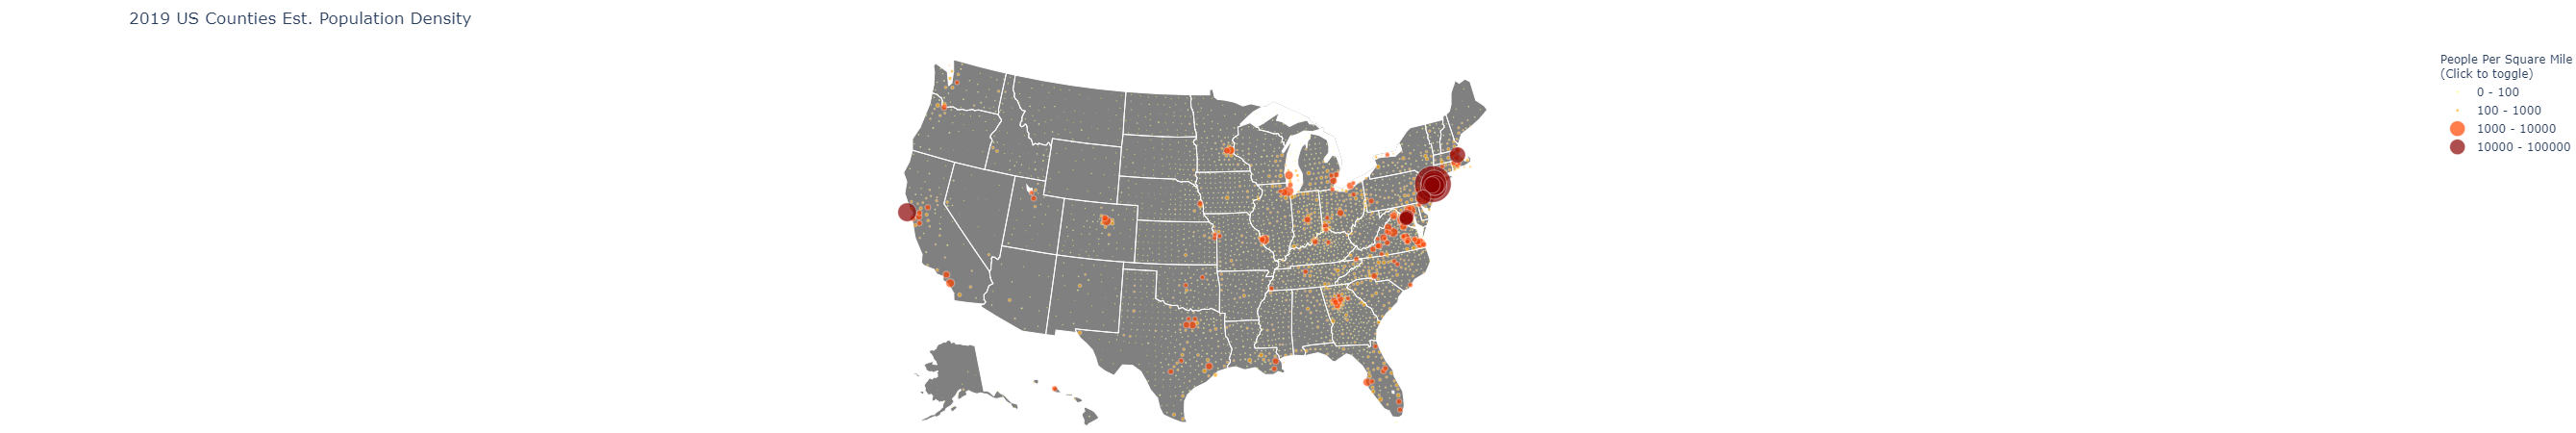

In [164]:
density_df = pd.concat(
    [county_df, tiger_df],
    join = 'inner',
    axis = 1
)

# ALAND = sq. km; * 0.386102 to get sq. miles
density_df['population_density'] = (
    density_df['POPESTIMATE2019'] /
    density_df['ALAND'].apply(lambda x: x * 0.386102) * 1000000
)
density_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
density_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

density_df.sort_values('population_density', ascending=False, inplace=True)

colors = ['darkred', 'orangered', 'orange', 'yellow']
limits = [(100000, 10000), (10000, 1000), (1000, 100), (100, 0)]
density_df['text'] = density_df['CTYNAME'] + '<br>' + (density_df['population_density'].apply(lambda x: round(x))).astype(str)+' Per Square Mile'

pop_density_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    df_sub = density_df.loc[(density_df['population_density'] < lim[0]) & (density_df['population_density'] > lim[1])]
    pop_density_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = df_sub['lat'],
        lon = df_sub['lon'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['population_density']/100,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))

pop_density_fig.update_layout(
    title_text = '2019 US Counties Est. Population Density',
    legend_title = 'People Per Square Mile<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={'r': 0, 't': 50, 'l': 0, 'b': 0}
)
pop_density_fig.show()

## CensusData Python Library
#### (for obtaining Median Home Value/Median Real Estate Tax) reference: https://pypi.org/project/CensusData/

In [161]:
# census api
census_key = os.getenv('CENSUS_API_KEY')

# https://jtleider.github.io/censusdata

# define dataset
dataset = {
    'B25077_001E': 'Median Home Value',
    'B25103_001E': 'Median Real Estate Tax',
    'B25121_001E': 'Median Household Income'
}
census_df = pd.DataFrame()

# download census data while concating data horizontally (2018 is the last year of data available)
for year in range(2012, 2019):
    data = censusdata.download(
        'acs5',
        year,
        censusdata.censusgeo([('county', '*')]),
        list(dataset.keys())
    )
    data['year'] = year
    data
    new_indices = []
    county_names = []
    for index in data.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(':')[0]
        county_names.append(county_name)
    data.index = new_indices
    data['county_name'] = county_names
    data.rename(dataset)
    census_df = pd.concat([census_df, data], axis=0)

census_df.rename(columns=dataset, inplace=True)
census_df['Real Estate Tax Rate'] = census_df['Median Real Estate Tax'] / census_df['Median Home Value']

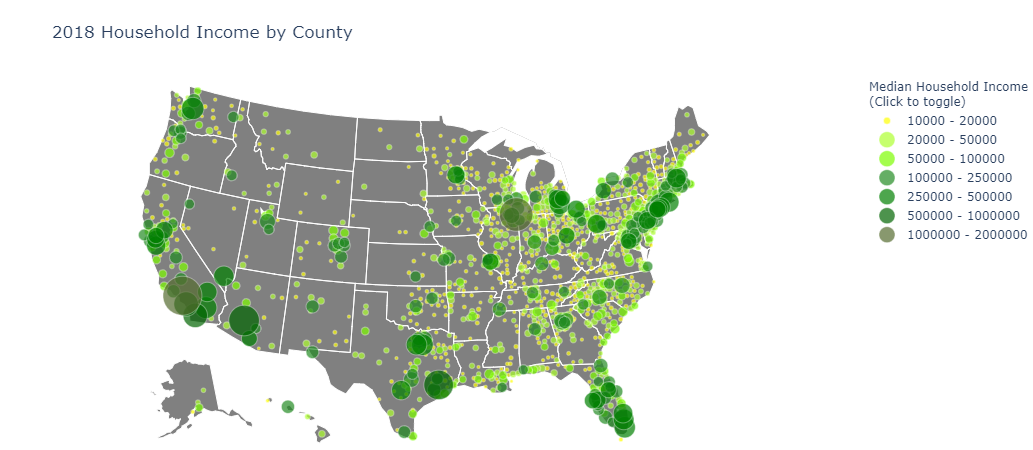

,Median Home Value,Median Real Estate Tax,Median Household Income,year,county_name,Real Estate Tax Rate,STATEFP,COUNTYFP,COUNTYNS,NAME,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,lat,lon,text
06037,543400.0,3938.0,1514629.0,2018,"Los Angeles County, California",0.007247,06,037,00277283,Los Angeles,...,31084,A,10511861492,1793485467,+34.1963983,-118.2618616,"MULTIPOLYGON (((-118.70339 34.16859, -118.7033...",34.196398,-118.261862,"Los Angeles County, California<br>Median House..."
17031,237200.0,4984.0,1116759.0,2018,"Cook County, Illinois",0.021012,17,031,01784766,Cook,...,16984,A,2447357982,1786325586,+41.8942937,-087.6454546,"POLYGON ((-88.23819 42.06698, -88.23819 42.067...",41.894294,-87.645455,"Cook County, Illinois<br>Median Household Inco..."
04013,242700.0,1489.0,933112.0,2018,"Maricopa County, Arizona",0.006135,04,013,00037026,Maricopa,...,None,A,23829622328,63347750,+33.3451756,-112.4989297,"POLYGON ((-112.27604 33.88231, -112.27667 33.8...",33.345176,-112.498930,"Maricopa County, Arizona<br>Median Household I..."
48201,165300.0,3356.0,865645.0,2018,"Harris County, Texas",0.020302,48,201,01383886,Harris,...,None,A,4418909573,184757689,+29.8572730,-095.3930371,"POLYGON ((-95.85685 29.87458, -95.85686 29.874...",29.857273,-95.393037,"Harris County, Texas<br>Median Household Incom..."
06073,526300.0,3868.0,593890.0,2018,"San Diego County, California",0.007349,06,073,00277301,San Diego,...,None,A,10904373558,817404622,+33.0236041,-116.7761174,"POLYGON ((-117.43743 33.17953, -117.44954 33.1...",33.023604,-116.776117,"San Diego County, California<br>Median Househo..."
06059,652900.0,4499.0,592269.0,2018,"Orange County, California",0.006891,06,059,00277294,Orange,...,11244,A,2053367783,401931862,+33.6756872,-117.7772068,"POLYGON ((-117.98910 33.58579, -117.99067 33.5...",33.675687,-117.777207,"Orange County, California<br>Median Household ..."
53033,493500.0,4611.0,494443.0,2018,"King County, Washington",0.009343,53,033,01531933,King,...,42644,A,5478557088,497719285,+47.4905993,-121.8339960,"POLYGON ((-122.47069 47.52789, -122.46985 47.5...",47.490599,-121.833996,"King County, Washington<br>Median Household In..."
06065,330600.0,3144.0,472401.0,2018,"Riverside County, California",0.009510,06,065,00277297,Riverside,...,None,A,18671212657,243883196,+33.7298275,-116.0022389,"POLYGON ((-117.67244 33.87026, -117.67257 33.8...",33.729827,-116.002239,"Riverside County, California<br>Median Househo..."
48113,161500.0,3124.0,459974.0,2018,"Dallas County, Texas",0.019344,48,113,01383842,Dallas,...,19124,A,2259439988,93869577,+32.7669866,-096.7784238,"POLYGON ((-96.52999 32.54528, -96.53330 32.545...",32.766987,-96.778424,"Dallas County, Texas<br>Median Household Incom..."
12086,268200.0,2610.0,449056.0,2018,"Miami-Dade County, Florida",0.009732,12,086,00295755,Miami-Dade,...,33124,A,4920565755,1376144237,+25.6105799,-080.4970989,"POLYGON ((-80.44093 25.95686, -80.44061 25.956...",25.610580,-80.497099,"Miami-Dade County, Florida<br>Median Household..."


In [190]:
income_df = pd.concat(
    [census_df.loc[census_df['year'] == 2018], tiger_df],
    join = 'inner',
    axis = 1
)

income_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
income_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

income_df.sort_values('Median Household Income', ascending=False, inplace=True)
colors = ['darkolivegreen', 'darkgreen', 'green', 'forestgreen', 'lawngreen', 'greenyellow', 'yellow']
limits = [(2000000, 1000000), (1000000, 500000), (500000, 250000), (250000, 100000), (100000, 50000), (50000, 20000), (20000, 10000)]
income_df['text'] = income_df['county_name'] + '<br>Median Household Income ' + (income_df['Median Household Income'].apply(lambda x: "${:.1f}K".format(x/1000))).astype(str)

income_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    income_sub = income_df.loc[(income_df['Median Household Income'] < lim[0]) & (income_df['Median Household Income'] > lim[1])]
    income_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = income_sub['lat'],
        lon = income_sub['lon'],
        text = income_sub['text'],
        marker = dict(
            size = income_sub['Median Household Income']/2000,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))

income_fig.update_layout(
    title_text = '2018 Household Income by County',
    legend_title = 'Median Household Income<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={"r":0,"t":75,"l":0,"b":0}
)
income_fig.show()
income_df.head(10)

In [6]:
# import plotly.figure_factory as ff

# fips = nycounty_fips # New York
# values = range(len(fips))

# fig = ff.create_choropleth(
#     fips=fips,
#     values=values,
#     scope=['New York']
# )
# fig.layout.template = None
# fig.show()

In [7]:
# population_fips = list(
#     county_df['STATE'].apply(lambda x: f'0{str(x)}'[-2:]) +
#     county_df['COUNTY'].apply(lambda x: f'00{str(x)}'[-3:])
# )

# import plotly.figure_factory as ff

# fips = nycounty_fips # New York
# values = range(len(fips))

# fig = ff.create_choropleth(
#     fips = population_fips,
#     values = county_df['RNETMIG2019'],
#     scope = ['usa']
# )
# fig.layout.template = None
# fig.show()

# import plotly.figure_factory as ff

# pxfig = px.choropleth(
#     population_df,
#     geojson=population_df['CTYNAME'],
#     locations='fips',
#     color='unemp',
#     color_continuous_scale="Viridis",
#     range_color=(0, 12),
#     scope="usa",
#     labels={'unemp':'unemployment rate'}
# )
# pxfig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# pxfig.show()

In [201]:
# Reference Quandl Zillow Research Documentation
# https://www.quandl.com/data/ZILLOW-Zillow-Real-Estate-Research/documentation

# function for calling quandl zillow api
def fetch_zillow_quandl(quandl_code, quandl_key):
    url = f'https://www.quandl.com/api/v3/datasets/ZILLOW/{quandl_code}?start_date=2012-01-01&end_date=2018-12-31&api_key={quandl_key}'
    response = json.loads(
        requests.get(url).content
    )
    return response['dataset']['data'] if response['dataset'] else None

# State = S
# County = CO
# Greater Metropolitan Area = M
# City = C
# Neighborhood = N
# Zip Code = Z

def zillow_codes(path, delimiter):
    csv_data = csv.DictReader(open(path), delimiter=delimiter)
    return list(map(lambda x: dict(x), csv_data))

In [192]:
city_lookup = zillow_codes('Quandl_Zillow_Research/city.txt', '|')
county_lookup = zillow_codes('Quandl_Zillow_Research/county.txt', '|')
metro_lookup = zillow_codes('Quandl_Zillow_Research/metro.txt', '|')
state_lookup = zillow_codes('Quandl_Zillow_Research/state.txt', '|')
indicators_lookup = zillow_codes('Quandl_Zillow_Research/indicators.csv', '|')

In [193]:
def match_locale_name(ctyname, lookup):
    ctyname = ctyname.lower().replace('st. ', 'saint ').replace("'s", '')
    matched_list = list(filter(lambda x: ctyname in x['AREA'].lower(), lookup))
    return f"CO{matched_list[0]['CODE']}" if matched_list else None
#     return matched_list[0] if matched_list else None

In [194]:
match_locale_name("Saint Mary", county_lookup)

'CO5402'

In [195]:
density_df['zcode'] = density_df['CTYNAME'].apply(
    lambda x: match_locale_name(x, county_lookup)
)

In [196]:
density_df.iloc[density_df['zcode'].to_list().index(None)]

index                                                     1231
SUMLEV                                                      50
REGION                                                       3
DIVISION                                                     5
STATE                                                       24
                                        ...                   
population_density                                     316.451
lat                                                    38.2203
lon                                                   -76.5304
text                  St. Mary's County<br>316 Per Square Mile
zcode                                                     None
Name: 24037, Length: 187, dtype: object

In [197]:
# select_indicators = list( filter( lambda x: 'all home' in x['INDICATOR'].lower(), indicators_lookup) )
# # print(fetch_zillow_quandl('CO3129_MRPFAH', quandl_key))
select_indicators = ['MVALFAH', 'PRRAH']
# indicators_lookup
select_indicators

['MVALFAH', 'PRRAH']

In [198]:
top_100_county = density_df[:100]

In [202]:
for indicator in select_indicators:
    top_100_county[indicator] = top_100_county['zcode'].apply(
        lambda x: fetch_zillow_quandl(f'{x}_{indicator}', quandl_key)
    )

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [203]:
top_100_county.head()

,index,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,...,INTPTLAT,INTPTLON,geometry,population_density,lat,lon,text,zcode,MVALFAH,PRRAH
36061,1891,50,1,2,36,61,New York,New York County,1585873,1586381,...,+40.7766419,-073.9701871,"MULTIPOLYGON (((-74.03294 40.68778, -74.02628 ...",71874.171308,40.776642,-73.970187,New York County<br>71874 Per Square Mile,CO3129,"[[2018-12-31, 437.0], [2018-11-30, 440.0], [20...","[[2018-12-31, 23.57], [2018-11-30, 23.79], [20..."
36047,1884,50,1,2,36,47,New York,Kings County,2504700,2504721,...,+40.6350451,-073.9506398,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",36901.389855,40.635045,-73.950640,Kings County<br>36901 Per Square Mile,CO5020,"[[2018-12-31, 127.0], [2018-11-30, 127.0], [20...","[[2018-12-31, 11.15], [2018-11-30, 11.34], [20..."
36005,1863,50,1,2,36,5,New York,Bronx County,1385108,1384580,...,+40.8487111,-073.8529390,"POLYGON ((-73.93365 40.88246, -73.93173 40.885...",33726.519557,40.848711,-73.852939,Bronx County<br>33727 Per Square Mile,CO3135,"[[2018-12-31, 182.0], [2018-11-30, 181.0], [20...","[[2018-12-31, 18.84], [2018-11-30, 18.74], [20..."
36081,1901,50,1,2,36,81,New York,Queens County,2230722,2230619,...,+40.6585662,-073.8380168,"POLYGON ((-74.03813 40.53829, -74.03749 40.542...",20719.750638,40.658566,-73.838017,Queens County<br>20720 Per Square Mile,CO3119,"[[2018-12-31, 635.0], [2018-11-30, 633.0], [20...","[[2018-12-31, 23.89], [2018-11-30, 23.71], [20..."
06075,228,50,4,9,6,75,California,San Francisco County,805235,805184,...,+37.7272391,-123.0322294,"MULTIPOLYGON (((-122.61228 37.81522, -122.5845...",18795.232030,37.727239,-123.032229,San Francisco County<br>18795 Per Square Mile,CO3175,"[[2018-12-31, 1707.0], [2018-11-30, 1717.0], [...","[[2018-12-31, 26.68], [2018-11-30, 26.21], [20..."


In [206]:
# headers = [['date', 'value']]
# county_df = pd.DataFrame(list(top_100_county.iloc[0]['MVALFAH']), columns=headers[0])
# county_df.set_index('date', inplace = True)
# county_df.sort_index(inplace = True)
# county_df.plot.line()


def median_value_per_square_foot(top_100_county):
    
    import panel as pn
    from panel.interact import interact
    pn.extension()

    def county_plot(County='New York County, New York'):
        mvalfah_headers = ['date', 'value']
        mvalfah = pd.DataFrame(list(top_100_county.loc[top_100_county['CTYNAME'] == County.split(', ')[0]]['MVALFAH'].to_list()[0]), columns=mvalfah_headers)
        mvalfah['date'] = mvalfah['date'].astype('datetime64[ns]')
        mvalfah.set_index('date', inplace = True)
        mvalfah.sort_index(inplace = True)
        
        prrah_headers = ['date', 'rate']
        prrah = pd.DataFrame(list(top_100_county.loc[top_100_county['CTYNAME'] == County.split(', ')[0]]['PRRAH'].to_list()[0]), columns=prrah_headers)
        prrah['date'] = prrah['date'].astype('datetime64[ns]')
        prrah.set_index('date', inplace = True)
        prrah.sort_index(inplace = True)
        
        mvalfah_plot = mvalfah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'value',
            yaxis = 'left',
            ylabel = 'Per Square Foot (USD)',
            title = f'{County} Median Home Value',
            width = 1000
        )
        
        prrah_plot = prrah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'rate',
            yaxis = 'right',
            ylabel = 'Home Price / Annual Rent',
            title = f'{County} Price to Rent Ratio',
            width = 1000
        )
        
        return mvalfah_plot * prrah_plot

    return interact(county_plot, County=sorted(list(top_100_county['CTYNAME'] + ', ' + top_100_county['STNAME'])))

In [207]:
# top_100_county.loc[top_100_county['CTYNAME'] == 'San Francisco County']['MVALFAH'].to_list()[0]
median_value_per_square_foot(top_100_county)

Column
    [0] Column
        [0] Select(name='County', options=['Alameda County, ...], value='New York County, ...)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01599')

In [26]:
def price_to_rent_ratio(top_100_county):
    
    import panel as pn
    from panel.interact import interact
    pn.extension()

    def county_plot(County='New York County, New York'):
        headers = ['date', 'value']
        county_df = pd.DataFrame(list(top_100_county.loc[top_100_county['CTYNAME'] == County.split(', ')[0]]['PRRAH'].to_list()[0]), columns=headers)
        county_df['date'] = county_df['date'].astype('datetime64[ns]')
        county_df.set_index('date', inplace = True)
        county_df.sort_index(inplace = True)
        
        return county_df.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'value',
            ylabel = 'Home Price / Annual Rent',
            title = f'{County} Price to Rent Ratio',
            width = 1000
        )

    return interact(county_plot, County=sorted(list(top_100_county['CTYNAME'] + ', ' + top_100_county['STNAME'])))

In [27]:
price_to_rent_ratio(top_100_county)

Column
    [0] Column
        [0] Select(name='County', options=['Alameda County, ...], value='New York County, ...)
    [1] Row
        [0] HoloViews(Curve, name='interactive01631')

In [52]:
df = pd.read_csv('County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,178760.0,...,642845.0,645665.0,647604.0,650650.0,653531.0,658238.0,662572.0,665835.0,665856.0,665016.0
1,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,151525.0,...,249610.0,249336.0,249065.0,248845.0,248790.0,248880.0,249115.0,249170.0,249236.0,249407.0
2,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,100844.0,...,199565.0,200127.0,200613.0,201135.0,201246.0,201651.0,202518.0,203554.0,204346.0,204793.0
3,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,117599.0,...,290055.0,291976.0,294022.0,296371.0,298667.0,300742.0,303160.0,306466.0,309311.0,311789.0
4,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,185243.0,...,614047.0,615494.0,618183.0,621275.0,625516.0,628650.0,632129.0,633962.0,636227.0,636815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,425,3101,Camas County,County,ID,ID,Hailey,16,25,NaN,...,118834.0,119295.0,120186.0,121049.0,121928.0,122341.0,122424.0,122522.0,122837.0,123173.0
2848,1648,3102,Daggett County,County,UT,UT,NaN,49,9,NaN,...,209766.0,210126.0,210680.0,210617.0,210554.0,210387.0,210742.0,210821.0,211042.0,211186.0
2849,2345,3112,Hinsdale County,County,CO,CO,NaN,8,53,NaN,...,324064.0,325482.0,326322.0,326715.0,326970.0,327198.0,327427.0,326036.0,325385.0,324790.0
2850,1933,3122,Mineral County,County,CO,CO,NaN,8,79,NaN,...,283702.0,283578.0,283220.0,282604.0,282542.0,282563.0,282656.0,282288.0,282028.0,281652.0


In [21]:
from pytrends.request import TrendReq
import time
startTime = time.time()
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['POTUS'])
df = pytrend.interest_by_region()
df.loc[df['POTUS'] != 0].sort_values(by='POTUS', ascending=False)

,POTUS
geoName,
Argentina,100
United States,79
Canada,56
Uruguay,53
Singapore,37
Australia,37
New Zealand,34
Kenya,33
Ireland,30


In [33]:
# kaggle https://github.com/Kaggle/kaggle-api#api-credentials